## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [10]:
import sys
!{sys.executable} -m pip install gdown h5py

In [11]:
import sys
import os

# Get the current working directory and navigate to the root directory
current_dir = os.getcwd()  # This will give you the current working directory
root_dir = os.path.abspath(os.path.join(current_dir, '..'))  # Go up one level to the root

# Add the root directory to the Python path
sys.path.insert(0, root_dir)

In [12]:
from src.utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "data/IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=2b7cf51e-a0a5-42a7-acb8-f3985b278f1c
To: /home/mroulet/nx414/visionary/data/IT_data.h5
100%|█████████████████████████████████████████████████████████████████████████████████████| 384M/384M [00:02<00:00, 132MB/s]


'data/IT_data.h5'

### Load the data

In [13]:
path_to_data = 'data' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [14]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channels (RGB)
The size of the image is 224x224


In [15]:
# check if data are stndardize - mean and std of stimulus_train of each channel
print("Sanity check on data...")
print("Mean and std of stimulus_train (data standardized already):")
for i in range(n_channels):
    mean = np.mean(stimulus_train[:, i, :, :])
    std = np.std(stimulus_train[:, i, :, :])
    print(f"Channel {i}: Mean = {mean:.4f}, Std = {std:.4f}")

# Check if there are any NaN or Inf values in the data
print(f"Any NaN in X_train: {np.any(np.isnan(stimulus_train))}")
print(f"Any Inf in X_train: {np.any(np.isinf(stimulus_train))}")
print("Data good. Proceeding with linear regression.")


Sanity check on data...
Mean and std of stimulus_train (data standardized already):
Channel 0: Mean = -0.1687, Std = 0.7872
Channel 1: Mean = -0.0430, Std = 0.8048
Channel 2: Mean = 0.1794, Std = 0.8012
Any NaN in X_train: False
Any Inf in X_train: False
Data good. Proceeding with linear regression.


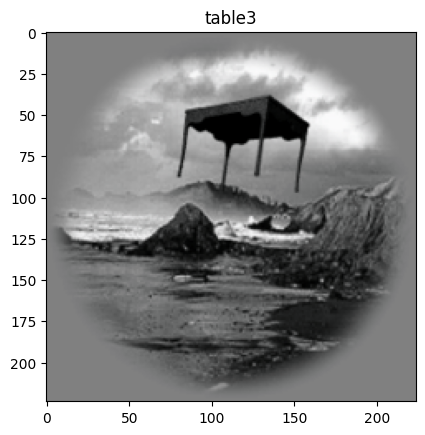

In [16]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

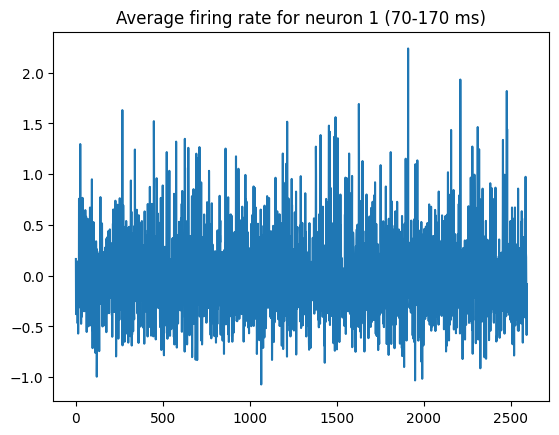

In [17]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import pickle
import time

#### Ridge Regression (closed-form solution)

In [ ]:

# Flatten images for regression
X_train = stimulus_train.reshape(stimulus_train.shape[0], -1)
X_val = stimulus_val.reshape(stimulus_val.shape[0], -1)
y_train = spikes_train
y_val = spikes_val

# cross-validation on alpha using ridgeCV
ridge_cv = RidgeCV(alphas=np.logspace(5,6,20), store_cv_results=True)

# Fit the model using RidgeCV and extract the best alpha
model = ridge_cv.fit(X_train, y_train)
print(f"Optimal alpha from cross-validation: {model.alpha_}")

# Predict on validation data
y_pred_train = ridge_cv.predict(X_train)
y_pred_val = ridge_cv.predict(X_val)

# Compute performance metrics
# Train metrics
print("Train metrics:")
r2 = r2_score(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
print(f"Ridge Regression (closed-form) R² (after CV): {r2:.4f}")
print(f"Ridge Regression (closed-form) MSE (after CV): {mse:.4f}")

# Validation metrics
print("Validation metrics:")
mse = mean_squared_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print(f"Ridge Regression (closed-form) R²: {r2:.4f}")
print(f"Ridge Regression (closed-form) MSE: {mse:.4f}")


##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

In [ ]:
def plot_neurons_metrics(y_val, y_pred):
    """
    Plot the correlation and explained variance for each neuron in a single figure.
    """
    correlations = np.array([np.corrcoef(y_val[:, i], y_pred[:, i])[0, 1] for i in range(y_val.shape[1])])
    explained_variance = np.array([explained_variance_score(y_val[:, i], y_pred[:, i]) for i in range(y_val.shape[1])])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Correlation Scatter Plot
    axes[0].scatter(y_val.flatten(), y_pred.flatten(), alpha=0.5)
    axes[0].plot([-1, 1], [-1, 1], linestyle='--', color='red')  # Diagonal line for slope 1
    axes[0].set_xlabel("True Neural Activity")
    axes[0].set_ylabel("Predicted Neural Activity")
    axes[0].set_title("Correlation of Predicted and True Neural Activity")
    
    # Explained Variance Plot
    axes[1].bar(range(y_val.shape[1]), explained_variance)
    axes[1].set_xlabel("Neuron Index")
    axes[1].set_ylabel("Explained Variance")
    axes[1].set_title("Explained Variance of Predicted Neural Activity")
    
    plt.tight_layout()
    plt.show()

plot_neurons_metrics(y_train, y_pred_train)
plot_neurons_metrics(y_val, y_pred_val)

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [ ]:
n_components = 1000
print(f"Applying PCA with {n_components} components...")
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

print("Training Ridge Regression on PCA-transformed data...")
model = RidgeCV(alphas=np.logspace(5,6,20), store_cv_results=True)
model.fit(X_train_pca, y_train)

print(f"Optimal alpha from cross-validation: {model.alpha_}")

y_pred_pca = model.predict(X_val_pca)
# Train metrics
print("Train metrics:")
r2 = r2_score(y_train, y_pred_pca)
mse = mean_squared_error(y_train, y_pred_pca)
print(f"Ridge Regression R² (after CV): {r2:.4f}")
print(f"Ridge Regression MSE (after CV): {mse:.4f}")
# Validation metrics
print("Validation metrics:")
r2 = r2_score(y_val, y_pred_pca)
mse = mean_squared_error(y_val, y_pred_pca)
print(f"Ridge Regression R² (after CV): {r2:.4f}")
print(f"Ridge Regression MSE (after CV): {mse:.4f}")

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [ ]:
#### Here your code

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, explained_variance_score
from torch.utils.data import DataLoader, TensorDataset

In [ ]:

# Get the activations for specific layers
class ResNet50TaskDriven(nn.Module):
    def __init__(self, model, layers):
        super(ResNet50TaskDriven, self).__init__()
        self.model = model
        self.layers = layers
    
    def forward(self, x):
        activations = {}
        for name, layer in self.model.named_children():
            x = layer(x)
            if name in self.layers:
                activations[name] = x
        return activations

# Load pre-trained ResNet50 model
resnet50_model = models.resnet50(pretrained=True)

# Define the layers to extract
layers_to_extract = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

# Create a new model to get the desired layers' activations
model_with_activations = ResNet50TaskDriven(resnet50_model, layers_to_extract)
model_with_activations.eval()  # Set to evaluation mode

In [ ]:

# Extract activations from each layer
def extract_activations(images, model, device):
    activations = []
    images = images.to(device)
    with torch.no_grad():
        activations = model(images)
    return activations

# Assume images is a batch of preprocessed images (a torch tensor)
# For example, you could load your images like this:
# images = torch.stack([preprocess(image) for image in image_list])
# Then, process the images in batches to avoid memory overload.

# Dummy image data for demonstration (you should replace this with your actual stimulus data)
dummy_images = torch.randn(1, 3, 224, 224)  # Replace with your image data

# Set device (CUDA if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Send the model to the appropriate device
model_with_activations = model_with_activations.to(device)

# Extract activations
activations = extract_activations(dummy_images, model_with_activations, device)



In [ ]:
def apply_pca_to_activations(activation, n_components=1000):
    # Flatten the activation for PCA
    activation = activation.view(activation.size(0), -1).cpu().numpy()  # Convert to NumPy array
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(activation)
    return pcs

# Apply PCA to the activations for each layer
pca_results = {}
for layer_name, activation in activations.items():
    print(f"Applying PCA to activations from layer: {layer_name}")
    pca_results[layer_name] = apply_pca_to_activations(activation)

# Now pca_results contains the PCA-transformed activations for each layer



In [ ]:
# Assuming y_train is the neural activity (spikes_train), and pca_results contains PCs for each layer

# Prepare input data for regression (flattened PCs)
X_train_pca = pca_results['conv1']  # Choose any layer, e.g., 'conv1'
y_train = spikes_train  # Assuming spikes_train is your neural activity data

# Train a Ridge Regression model using the PCs of the chosen layer
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_pca, y_train)

# Predict neural activity using the trained model
y_pred = ridge_model.predict(X_train_pca)

# Evaluate the performance (R2 and Explained Variance)
r2 = r2_score(y_train, y_pred)
ev = explained_variance_score(y_train, y_pred)

print(f"R²: {r2:.4f}")
print(f"Explained Variance: {ev:.4f}")


In [ ]:
def plot_explained_variance_across_layers(layers, pca_results, y_train):
    explained_variances = []
    
    for layer_name, pcs in pca_results.items():
        # Fit Ridge Regression on the PCs of each layer
        ridge_model = Ridge(alpha=1.0)
        ridge_model.fit(pcs, y_train)
        
        # Predict and calculate explained variance
        y_pred = ridge_model.predict(pcs)
        ev = explained_variance_score(y_train, y_pred)
        explained_variances.append(ev)
    
    # Plot the explained variance for each layer
    plt.figure(figsize=(10, 6))
    plt.bar(layers, explained_variances)
    plt.xlabel("Layer")
    plt.ylabel("Explained Variance")
    plt.title("Explained Variance for Each Layer of ResNet50")
    plt.xticks(rotation=45)
    plt.show()

# Plot the explained variance across layers
plot_explained_variance_across_layers(layers_to_extract, pca_results, spikes_train)
